# Usage

Step1. Direct_density_ratio_estimation_uLSIF_python.pyがあるディレクトリを読めるようにする。

In [1]:
import sys
sys.path.append('src/')

Step2. Direct_density_ratio_estimation_uLSIFで使用するモジュールをインポートする。

In [2]:
import numpy as np
import random as rand
import Direct_density_ratio_estimation_uLSIF_python as density

In [3]:
#データ表示に必要。
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification, make_circles, make_moons
import seaborn as sns
sns.set_style('white')
import pandas as pd
import scipy.stats as scipy_stats
from sklearn.datasets import make_classification

## test

### ガウス分布の異常検知

In [4]:
#
N_norm = 500
N_anom = 300
m = [10.,11.]
s = [0.5,1.2]
x_norm = np.random.normal(loc= m[0], scale = s[0], size = N_norm)
y_anom = np.random.normal(loc= m[1], scale = s[1], size = N_anom)
Tot = np.r_[x_norm,y_anom]

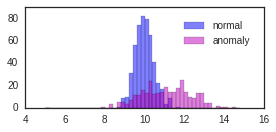

In [8]:
# 表示
fig = plt.figure(figsize=[4,2])
ax = fig.add_subplot(111)
edges = np.arange(5,15,0.2)
a = ax.hist(x_norm, bins = edges, color='b', alpha = 0.5, label='normal')
b = ax.hist(y_anom, bins = edges, color='m', alpha = 0.5, label='anomaly')
ylim = 1.1*np.max([a[0],b[0]])
ax.set_ylim(0,ylim)
ax.legend(fontsize = 10, bbox_to_anchor = (1,1), loc='upper right', borderaxespad = 1)
fig.show()
plt.tight_layout()

normalに対して normal+anomalyの密度比を計算する

In [9]:
dens = density.Density_ratio_estimation(x_norm,y_anom)
dens.run()

start calculate density ratio using uLSIF.
search sigma and lambda
sigma = 0.0010, lambda = 0.0010, score = -0.0003
sigma = 0.0032, lambda = 0.0010, score = -0.0074
sigma = 0.0100, lambda = 0.0010, score = -0.0649
sigma = 0.0316, lambda = 0.0010, score = -0.5692
sigma = 0.1000, lambda = 0.0100, score = -0.8771
sigma = 0.3162, lambda = 0.0316, score = -1.0351
sigma = 0.3162, lambda = 0.1000, score = -1.1335
sigma = 0.3162, lambda = 0.3162, score = -1.1503
optimal sigma = 0.3162, lamda = 0.3162
alpha optimization
alpha optimization end
start calculate density ratio using uLSIF.


#### 実際の分布の密度比と推定した密度比との比較

(0, 20)

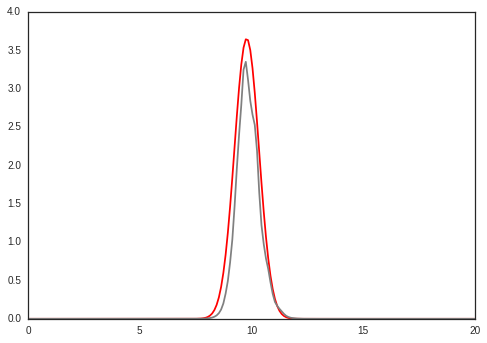

In [10]:
x = np.linspace(0,20,200)
y1 = scipy_stats.norm.pdf(x,loc=m[0],scale=s[0])
y2 = scipy_stats.norm.pdf(x,loc=m[1],scale=s[1])
y3 = (y1/y2)
w_hat = dens.calculate_density_ratio(x)
plt.figure()
plt.plot(x,y3,'r',label='w')
plt.plot(x,w_hat,'gray',label='w estimate')
plt.xlim(0,20)

使い方的なもの

コンストラクタを作成する際に、密度比を推定するためのデータを入力する。   
例えば、   
$\bf x$=[[$x^1_1,x^1_2,...,x^1_k$],
         [$x^2_1,x^2_2,...,x^2_k$],...
         [$x^n_1,x^n_2,...,x^n_k$]]
 
 上添字がイベントデータ番号(n)   
 下添字がイベントに含まれる特徴量(観測量)

classの中身の関数を表示。

In [11]:
for x in dir(dens):
    print x

_Density_ratio_estimation__kernel_num
_Density_ratio_estimation__lambda
_Density_ratio_estimation__results
_Density_ratio_estimation__sigma
_Density_ratio_estimation__x
_Density_ratio_estimation__y
__doc__
__init__
__module__
_core
_fn_calculate_kernel_gauss
_fn_search_sigma_lambda
_fn_uLSIF
calculate_density_ratio
get_alpha
get_lambda
get_results
get_sigma
get_x
get_y
help
run
set_optional_lambda
set_optional_sigma


runでコンストラクタに入力されたデータ同士($\bf x,\bf y$)の密度比($p({\bf x})/q({\bf y})$)計算を行う。   
get_alphaでカーネル関数の重み付けが返る。   
get_lambdaで最小問題解いた時の罰則項が返る。   
get_xで分子に使ったデータ    
get_yで分母に使ったデータ   
set_optional_lamdaは、罰則項の値を任意に固定できる。   
set_optional_sigmaは、カーネル関数のバンド幅を任意に固定できる。   
calculate_density_ratioは、入力された値($\bf z$)における密度比$p({\bf z})/q({\bf z})$が返る。

#### 変化点検知

正常時の分布から得られた密度比を異常度に計算し直して、正常時の上5%を異常と定義する。   
上5%を超えたものが連続して現れたら異常状態とする。

In [12]:
anom_percentile = 5 #正常時の異常度上0.5%を異常とする。
w_hat_norm = np.asanyarray(dens.calculate_density_ratio(x_norm)) #正常時の密度比
w_hat = np.asanyarray(dens.calculate_density_ratio(x_norm))
anom_score_norm = -np.log(w_hat_norm) #密度比を情報エントロピーに変換
anom_score = -np.log(w_hat)

thresh = np.percentile(anom_score_norm,100.-anom_percentile)
cumsum_anom = np.cumsum(list(map(lambda x: 1-anom_percentile/100. if x > thresh else -anom_percentile/100., anom_score))) #異常が現れた回数を重み付けして足していく。正常時のときには平均が0になるように調整。

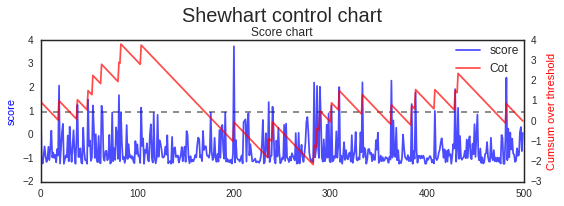

In [13]:
#
fig = plt.figure()

fig = plt.figure(figsize=(8,3))
ax20 = plt.subplot(111)

ax20_1 = ax20
ax20_2 = ax20.twinx()
ax20_1.hlines(y=thresh,xmin=0,xmax=len(anom_score),colors='k',linestyles='--',alpha=0.5)
p1 = ax20_1.plot(anom_score, alpha=0.7, label = 'score', color='b')
p2 = ax20_2.plot(cumsum_anom,alpha=0.7, label = 'Cot', color='r')
p = p1+p2
ax20_1.legend(p,[i.get_label() for i in p],
              fontsize=12, bbox_to_anchor=(1,1),
              loc='upper right',borderaxespad=0).get_frame().set_alpha(0.6)
ax20_1.set_ylabel('score',color='b')
ax20_2.set_ylabel('Cumsum over threshold',color='r')
ax20.set_title('Score chart')

fig.suptitle('Shewhart control chart',fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 多変量正規分布

In [14]:
#
NUM_MIXTURE_COMPONENTS = 2
NUM_DIMENSIONS = 2
def create_data(num_samples, seed = None):
    if seed is not None:
        np.random.seed(seed)
    weights = np.random.random(NUM_MIXTURE_COMPONENTS)
    weights = (weights/ weights.sum()).tolist()
    
    feature_vectors, labels = make_classification(n_samples=num_samples,
                                                  n_features=NUM_DIMENSIONS, 
                                                  n_redundant=0,
                                                  n_classes=NUM_MIXTURE_COMPONENTS, 
                                                  n_clusters_per_class=1,
                                                  weights=weights)
    plt.scatter(feature_vectors[:,0],feature_vectors[:,1],marker='o')
    plt.show()
    return feature_vectors

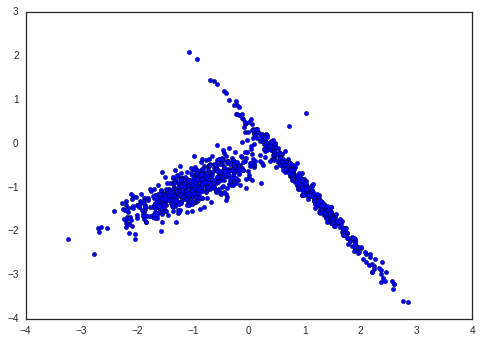

In [15]:
vectors_norm = create_data(1000,87)

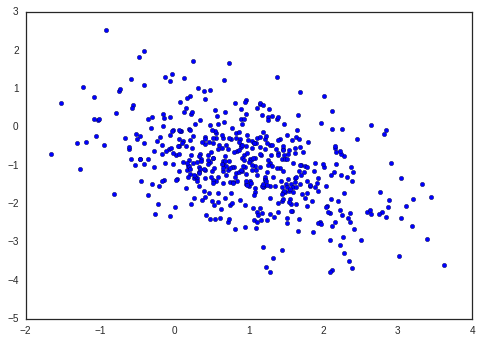

In [16]:
vectors_anom = create_data(500,106)

In [19]:
Tot = np.r_[vectors_norm,vectors_anom]
Test = density.Density_ratio_estimation(vectors_norm,Tot)
Test.run()

start calculate density ratio using uLSIF.
search sigma and lambda
sigma = 0.0010, lambda = 0.0010, score = 0.0000
sigma = 0.0010, lambda = 10.0000, score = -0.0000
sigma = 0.0100, lambda = 0.0010, score = -0.0000
sigma = 0.0316, lambda = 0.0010, score = -0.0010
sigma = 0.1000, lambda = 0.0010, score = -0.1061
sigma = 0.3162, lambda = 0.0010, score = -0.3878
sigma = 0.3162, lambda = 0.0032, score = -0.4253
sigma = 0.3162, lambda = 0.0100, score = -0.4298
sigma = 0.3162, lambda = 0.0316, score = -0.4322
sigma = 1.0000, lambda = 0.1000, score = -0.4392
sigma = 1.0000, lambda = 0.3162, score = -0.4541
sigma = 1.0000, lambda = 1.0000, score = -0.4654
sigma = 1.0000, lambda = 3.1623, score = -0.4764
sigma = 3.1623, lambda = 1.0000, score = -0.4989
sigma = 3.1623, lambda = 3.1623, score = -0.4994
sigma = 10.0000, lambda = 0.3162, score = -0.5000
optimal sigma = 10.0000, lamda = 0.3162
alpha optimization
alpha optimization end
start calculate density ratio using uLSIF.


In [21]:
#
anom_percentile = 0.5 #正常時(異常データが正常データに比べて十分少ないとき)の推定した密度比の下側5%以下をエラーとする。例えば、学校のテストの点数が低い人下から5%をエラーと仮定する。
w_hat_norm = np.asanyarray(Test.calculate_density_ratio(vectors_norm)) #正常時の密度比
w_hat = np.asanyarray(Test.calculate_density_ratio(Tot))
anom_score_norm = -np.log(w_hat_norm) #密度比を情報エントロピーに変換
anom_score = -np.log(w_hat)
thresh = np.percentile(anom_score_norm,100.-anom_percentile)
cumsum_anom = np.cumsum(list(map(lambda x: 1-anom_percentile/100. if x > thresh else -anom_percentile/100., anom_score))) #異常が現れた回数を重み付けして足していく。正常時のときには平均が0になるように調整。

In [22]:
df1 = pd.DataFrame(Test.get_x(),columns=['feature1','feature2'])
df1['State'] = ['Normal' for i in range(len(df1))]
df2 = pd.DataFrame(Test.get_y(),columns=['feature1','feature2'])
df2['State'] = ['Normal+Anom' for i in range(len(df2))]
df = df1.append(df2)

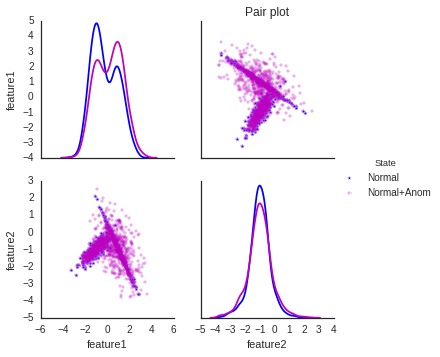

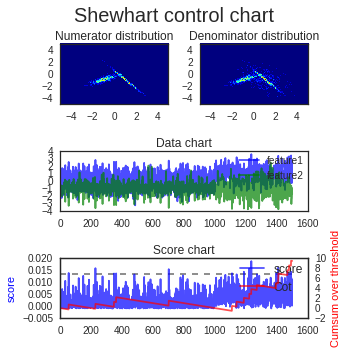

In [23]:
#
sns.set_style('white')
fig = plt.figure()

sns.pairplot(df,
             hue="State",
             markers=["*","+"],
             palette={"Normal": "b", "Normal+Anom": "m"},
             vars=['feature1','feature2'],
             diag_kind = 'kde')
sns.plt.title('Pair plot')
fig.show()

fig = plt.figure(figsize=(5,5))
ax00 = plt.subplot2grid((3,2),(0,0))
ax01 = plt.subplot2grid((3,2),(0,1))
ax10 = plt.subplot2grid((3,2),(1,0),colspan=2)
ax20 = plt.subplot2grid((3,2),(2,0),colspan=2)

edges = np.linspace(-5,5,100)
ax00.hist2d(Test.get_x()[:,0],Test.get_x()[:,1],bins=[edges,edges],cmap=plt.get_cmap('jet'),normed=True)
ax01.hist2d(Test.get_y()[:,0],Test.get_y()[:,1],bins=[edges,edges],cmap=plt.get_cmap('jet'),normed=True)
ax00.set_title('Numerator distribution')
ax01.set_title('Denominator distribution')

ax10.plot(Test.get_y()[:,0],color='b',alpha=0.7,label='feature1')
ax10.plot(Test.get_y()[:,1],color='g',alpha=0.7,label='feature2')
ax10.legend(bbox_to_anchor=(1,1),loc='upper right',borderaxespad=0).get_frame().set_alpha(0.6)
ax10.set_title('Data chart')

ax20_1 = ax20
ax20_2 = ax20.twinx()
ax20_1.hlines(y=thresh,xmin=0,xmax=len(anom_score),colors='k',linestyles='--',alpha=0.5)
p1 = ax20_1.plot(anom_score, alpha=0.7, label = 'score', color='b')
p2 = ax20_2.plot(cumsum_anom,alpha=0.7, label = 'Cot', color='r')
p = p1+p2
ax20_1.legend(p,[i.get_label() for i in p],
              fontsize=12, bbox_to_anchor=(1,1),
              loc='upper right',borderaxespad=0).get_frame().set_alpha(0.6)
ax20_1.set_ylabel('score',color='b')
ax20_2.set_ylabel('Cumsum over threshold',color='r')
ax20.set_title('Score chart')

fig.suptitle('Shewhart control chart',fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 一様分布

In [26]:
x = np.random.uniform(low=5,high=10,size=700)
y = np.random.uniform(low=0,high=10,size=600)
dens = density.Density_ratio_estimation(x,y)
dens.run()

start calculate density ratio using uLSIF.
search sigma and lambda
sigma = 0.0010, lambda = 0.0010, score = -0.0000
sigma = 0.0032, lambda = 0.0010, score = -0.0019
sigma = 0.0100, lambda = 0.0010, score = -0.0289
sigma = 0.0316, lambda = 0.0010, score = -0.1802
sigma = 0.1000, lambda = 0.0010, score = -0.2669
sigma = 0.1000, lambda = 0.0032, score = -0.6946
sigma = 0.3162, lambda = 0.0100, score = -0.9383
sigma = 0.3162, lambda = 0.0316, score = -0.9694
optimal sigma = 0.3162, lamda = 0.0316
alpha optimization
alpha optimization end
start calculate density ratio using uLSIF.


(0, 20)

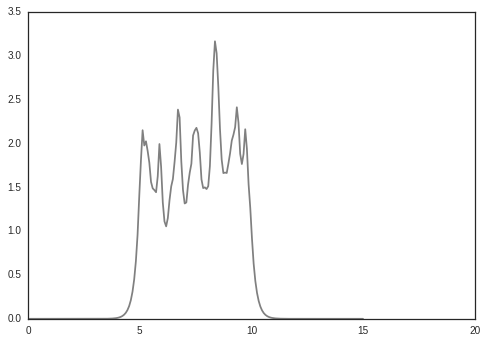

In [30]:
x = np.linspace(0,15,200)
w_hat = dens.calculate_density_ratio(x)
plt.figure()
#plt.plot(x,y3,'r',label='w')
plt.plot(x,w_hat,'gray',label='w estimate')
plt.xlim(0,20)

### その他分布

In [73]:
vectors_norm, y = make_circles(noise=0.05,factor=0.2,n_samples=500)
vectors_anom, y = make_circles(noise=0.1,factor=0.8,n_samples=200)
Tot = np.r_[vectors_norm,vectors_anom]
Test = density.Density_ratio_estimation(vectors_norm,Tot)
Test.run()

start calculate density ratio using uLSIF.
search sigma and lambda
sigma = 0.0010, lambda = 0.0010, score = -0.0000
sigma = 0.0032, lambda = 0.0010, score = -0.0000
sigma = 0.0100, lambda = 0.0010, score = -0.0001
sigma = 0.0316, lambda = 0.0010, score = -0.0076
sigma = 0.1000, lambda = 0.0010, score = -0.2174
sigma = 0.3162, lambda = 0.0010, score = -0.4145
sigma = 0.3162, lambda = 0.0032, score = -0.4426
sigma = 0.3162, lambda = 0.0100, score = -0.4476
sigma = 1.0000, lambda = 0.3162, score = -0.4823
sigma = 1.0000, lambda = 1.0000, score = -0.4881
sigma = 1.0000, lambda = 3.1623, score = -0.4906
sigma = 3.1623, lambda = 0.1000, score = -0.4958
sigma = 3.1623, lambda = 0.3162, score = -0.4999
sigma = 3.1623, lambda = 1.0000, score = -0.4999
sigma = 10.0000, lambda = 0.0316, score = -0.5000
sigma = 10.0000, lambda = 0.1000, score = -0.5000
optimal sigma = 10.0000, lamda = 0.1000
alpha optimization
alpha optimization end
start calculate density ratio using uLSIF.


In [74]:
anom_percentile = 10 #正常時(異常データが正常データに比べて十分少ないとき)の推定した密度比の下側5%以下をエラーとする。例えば、学校のテストの点数が低い人下から5%をエラーと仮定する。
w_hat_norm = np.asanyarray(Test.calculate_density_ratio(vectors_norm)) #正常時の密度比
w_hat = np.asanyarray(Test.calculate_density_ratio(Tot))
anom_score_norm = -np.log(w_hat_norm) #密度比を情報エントロピーに変換
anom_score = -np.log(w_hat)
thresh = np.percentile(anom_score_norm,100.-anom_percentile)
cumsum_anom = np.cumsum(list(map(lambda x: 1-anom_percentile/100. if x > thresh else -anom_percentile/100., anom_score))) #異常が現れた回数を重み付けして足していく。正常時のときには平均が0になるように調整。

In [75]:
df1 = pd.DataFrame(Test.get_x(),columns=['feature1','feature2'])
df1['State'] = ['Normal' for i in range(len(df1))]
df2 = pd.DataFrame(Test.get_y(),columns=['feature1','feature2'])
df2['State'] = ['Normal+Anom' for i in range(len(df2))]
df = df1.append(df2)

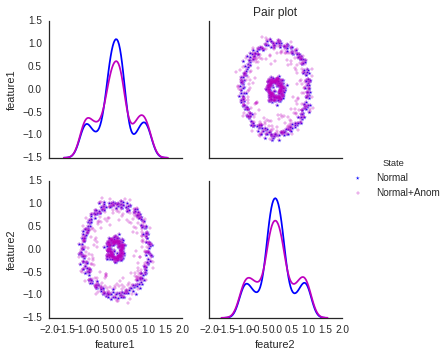

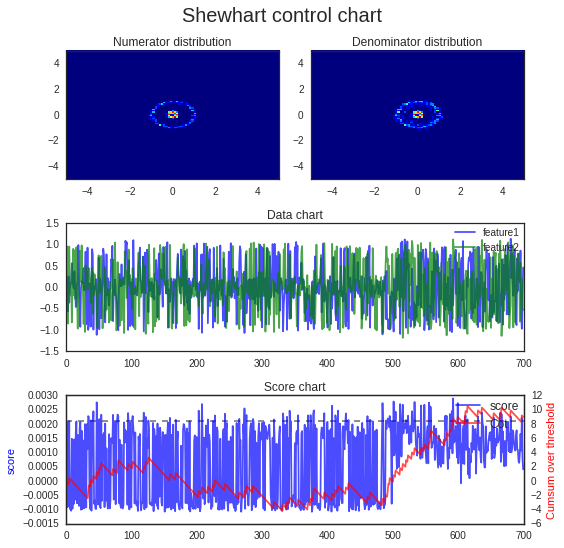

In [76]:
#
sns.set_style('white')
fig = plt.figure()

sns.pairplot(df,
             hue="State",
             markers=["*","+"],
             palette={"Normal": "b", "Normal+Anom": "m"},
             vars=['feature1','feature2'],
             diag_kind = 'kde')
sns.plt.title('Pair plot')
fig.show()

fig = plt.figure(figsize=(8,8))
ax00 = plt.subplot2grid((3,2),(0,0))
ax01 = plt.subplot2grid((3,2),(0,1))
ax10 = plt.subplot2grid((3,2),(1,0),colspan=2)
ax20 = plt.subplot2grid((3,2),(2,0),colspan=2)

edges = np.linspace(-5,5,100)
ax00.hist2d(Test.get_x()[:,0],Test.get_x()[:,1],bins=[edges,edges],cmap=plt.get_cmap('jet'),normed=True)
ax01.hist2d(Test.get_y()[:,0],Test.get_y()[:,1],bins=[edges,edges],cmap=plt.get_cmap('jet'),normed=True)
ax00.set_title('Numerator distribution')
ax01.set_title('Denominator distribution')

ax10.plot(Test.get_y()[:,0],color='b',alpha=0.7,label='feature1')
ax10.plot(Test.get_y()[:,1],color='g',alpha=0.7,label='feature2')
ax10.legend(bbox_to_anchor=(1,1),loc='upper right',borderaxespad=0).get_frame().set_alpha(0.6)
ax10.set_title('Data chart')

ax20_1 = ax20
ax20_2 = ax20.twinx()
ax20_1.hlines(y=thresh,xmin=0,xmax=len(anom_score),colors='k',linestyles='--',alpha=0.5)
p1 = ax20_1.plot(anom_score, alpha=0.7, label = 'score', color='b')
p2 = ax20_2.plot(cumsum_anom,alpha=0.7, label = 'Cot', color='r')
p = p1+p2
ax20_1.legend(p,[i.get_label() for i in p],
              fontsize=12, bbox_to_anchor=(1,1),
              loc='upper right',borderaxespad=0).get_frame().set_alpha(0.6)
ax20_1.set_ylabel('score',color='b')
ax20_2.set_ylabel('Cumsum over threshold',color='r')
ax20.set_title('Score chart')

fig.suptitle('Shewhart control chart',fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()